# IoT Streaming Data and Deep Learning for Predictive Maintenance


When dealing with hardware devices that drive a business, hardware failure can be a big cost.  Corrective maintenance after hardware has failed can lead to unexpected downtimes of services, and inefficient maintenance operations.  On the other hand, preventative maintenance can lead to higher costs when prevenatively servicing hardware that is in good condition.

A better approach is to use **predictive maintenance**.  If we can monitor our hardware and predict when it will fail, we can schedule maintenance before the failure, avoiding unexpected downtimes, allowing for efficient maintenance scheduling, and saving on cost of unnecessary service.

In this analysis we use streaming IoT sensor data to track the state of a SCARA (Selective Compliance Assembly Robot Arm) Robot.  We then train a **recurrent neural network model with Tensorflow** to detect anomalies that may indicate calibration errors and impending failure.

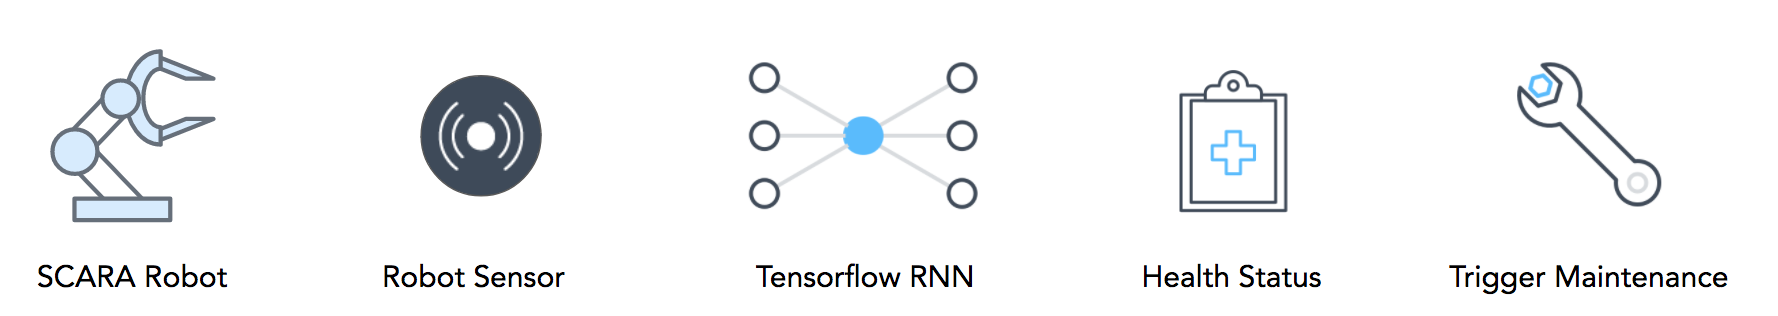

When anomalies are detected, alerts can be sent to trigger maintenance request before the anomalous readings lead to failures.

In [6]:
import os
import pandas as pd
import csv
import numpy as np
import random
import glob
import matplotlib
import matplotlib.pyplot as plt
import random
import plotly
%matplotlib inline

#import tensorflow libraries
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import subprocess

In [4]:
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Data

Our sensor measures multiple physical aspects of the SCARA robot.  The readings include such things as position, torque, and speed along different axes of motion.  We can take a quick look at our data in the table below.

In [9]:
# Import the data from MapR

# We can open a pipe to files on the hadoop file system, and stream the data as we need it.
# Here we read the small training data all at once, but we can also stream it line by line
# when dealing with bigger data using an example like this:
    # from itertools import islice
    # start_line = 5
    # end_line = 100
    # list(islice(csv_stream.stdout, start_line, end_line))
    
csv_stream = subprocess.Popen(["hadoop", "fs", "-cat", "/data/predictive-maintenance/training-set/part-00000-45866095-f76d-4f6c-ba2d-a07f0ab2dc04.csv"], stdout=subprocess.PIPE)
df = pd.read_csv(csv_stream.stdout).sort_values(['TimeStamp'], ascending=True).reset_index()

df.drop(['::[scararobot]Ax_J1.PositionCommand','::[scararobot]Ax_J1.TorqueFeedback','::[scararobot]Ax_J2.PositionCommand','::[scararobot]Ax_J2.TorqueFeedback','::[scararobot]Ax_J3.TorqueFeedback','::[scararobot]Ax_J6.TorqueFeedback','::[scararobot]ScanTimeAverage','::[scararobot]Ax_J6.PositionCommand','::[scararobot]Ax_J3.PositionCommand','index'], axis=1, inplace=True)
df['TimeStamp']=pd.to_datetime(df['TimeStamp'])
df.head(5)

,TimeStamp,::[scararobot]Ax_J1.ActualPosition,::[scararobot]Ax_J1.PositionError,::[scararobot]Ax_J1.TorqueCommand,::[scararobot]Ax_J2.ActualPosition,::[scararobot]Ax_J2.PositionError,::[scararobot]Ax_J2.TorqueCommand,::[scararobot]Ax_J3.ActualPosition,::[scararobot]Ax_J3.PositionError,::[scararobot]Ax_J3.TorqueCommand,::[scararobot]Ax_J6.ActualPosition,::[scararobot]Ax_J6.PositionError,::[scararobot]Ax_J6.TorqueCommand,::[scararobot]CS_Cartesian.ActualPosition[0],::[scararobot]CS_Cartesian.ActualPosition[1],::[scararobot]CS_Cartesian.ActualPosition[2],::[scararobot]CS_SCARA.ActualPosition[0],::[scararobot]CS_SCARA.ActualPosition[1],::[scararobot]CS_SCARA.ActualPosition[2],::[scararobot]speed
0,2016-07-22 14:02:54.084,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0
1,2016-07-22 14:02:54.134,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0
2,2016-07-22 14:02:54.137,60.671337,0.37341,12.8,-55.189659,0.015765,2.7,10.6520,0.630938,57.000000,-338.295074,-2.640736,-11.2,307.978271,177.130295,-0.15839,60.671337,-55.189659,-0.15839,100.0
3,2016-07-22 14:02:54.184,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0
4,2016-07-22 14:02:54.187,61.989475,0.37836,12.8,-55.172352,0.015171,2.8,10.8535,0.634250,56.700001,-343.970001,-2.544077,-10.5,303.798065,184.259003,-0.14125,61.989475,-55.172352,-0.14125,100.0


Sometimes the data we get from the sensor seems out of step with the pattern before and after.  These anomalies may be innocuous, or may indicate a problem with the SCARA Robot, especially as they become more frequent.  For example, we can see unusual spikes in the sensor readings below.

In [10]:
#%%local
trace1 = go.Scatter(
    x = df['TimeStamp'].iloc[80000:],
    y = df['::[scararobot]Ax_J1.ActualPosition'].iloc[80000:]
)
trace2 = go.Scatter(
    x = df['TimeStamp'].iloc[80000:],
    y = df['::[scararobot]Ax_J3.TorqueCommand'].iloc[80000:]
)

layout = dict(height=300, title = 'Sensor Readings Over Time', yaxis=dict(title='Position'))
fig = dict(data=[trace1], layout = layout)
iplot(fig)


layout = dict(height=300, xaxis = dict(title='Time'), yaxis=dict(title='Torque<br>Command'))
fig = dict(data=[trace2], layout = layout)
iplot(fig)

## Aggregating Sensor Data

When we explore our data we notice that when one measurement of the sensor shows an anomaly, most of the others do as well.  To simplify our model we can aggreagete the sensor readings into one feature and train a model on those.  

Later, we can compare that by training multiple models, one for each type of sensor reading.

In [12]:
# Aggregate sensor data and prepare it for the model

#remove rows that are all zeros
df1 = df[df["::[scararobot]speed"] != 0].set_index('TimeStamp')   

#create a new column that will be our feature variable for our model
df1['Total']= df1.select_dtypes(include=['float64','float32']).apply(lambda row: np.sum(row),axis=1)
trace = go.Scatter(
    x = df1.index[27000:28000],
    y = df1['Total'].iloc[27000:28000]
)


layout = dict(title = 'Aggregate Readings Over Time', height=400)
fig = dict(data=[trace], layout=layout)
iplot(fig)

## Training a Recurrent Neural Network Using Tensorflow

We can detect potential failures by looking at the aggregate of the different readings in our sensor data.  The network will learn to predict the expected sensor readings.  When the sensor readings deviate from those expected, this indicates an anomaly in the robot's calibration that may signal impending failure.  

We can use these detections to schedule maintenance before failures occur.

In [11]:
#convert into a time series object
ts = pd.Series(df1['Total'])

#prepare data and inputs for our TF model
num_periods = 100
f_horizon = 1       #number of periods into the future we are forecasting
TS = np.array(ts)   #convert time series object to an array

#create our training input data set "X"
x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, num_periods, 1)


#create our training output dataset "y"
y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)


#create our test X and y data
def test_data(series,forecast,num_periods):
    test_x_setup = series[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = TS[-(num_periods):].reshape(-1, num_periods, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods)

In [13]:
#set up our TF model parameters

tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs], name = "X")   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output], name = "y")


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y),name='loss')    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()

epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

mse_list = []
epoch_list = []
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            mse_list.append(mse)
            epoch_list.append(ep)
            print "Epoch: " + str(ep) + "\tMSE: " + str(mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    #print(y_pred[:,(num_periods-1):num_periods])
    
    saver = tf.train.Saver()   #we are going to save the model
    DIR="model"  #path where the model will be saved
    saver.save(sess, os.path.join(DIR,"RWsensorTFmodel"),global_step = epochs)




Epoch: 0	MSE: 1.42171e+09
Epoch: 100	MSE: 5.54022e+07
Epoch: 200	MSE: 4.45531e+07
Epoch: 300	MSE: 3.79746e+07
Epoch: 400	MSE: 3.44169e+07
Epoch: 500	MSE: 3.20073e+07
Epoch: 600	MSE: 2.82806e+07
Epoch: 700	MSE: 2.72746e+07
Epoch: 800	MSE: 2.50295e+07
Epoch: 900	MSE: 2.35856e+07


## Model Performance



In [14]:
trace = go.Scatter(
    x = epoch_list[1:],
    y = mse_list[1:]
)


layout = dict(
              xaxis = dict(title = 'Training Epoch'),
              yaxis = dict(title = 'Error'),
              height = 400
              )
fig = dict(data=[trace], layout=layout)
iplot(fig)

## Detecting Anomalies

When the expected value of the sensor deviates too much from the actual reading, this indicates an anomaly.  We can see in the figure below when our robot may need maintenance when the 'predicted' trace and the 'observed' trace strongly differ from each other. 

In [15]:
test_series = pd.Series(np.ravel(Y_test))
trace1 = go.Scatter(
    x = test_series.index,
    y = test_series,
    mode='markers',
    marker = dict(
        size = 10)
)

pred_series = pd.Series(np.ravel(y_pred))
trace2 = go.Scatter(
    x = pred_series.index,
    y = pred_series,
    mode = 'markers'
)
layout = dict(xaxis = dict(title = 'Time Periods'),yaxis = dict(title = 'Aggregate Sensor Readings'),
              )
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)

In [7]:
#import the data from MapR
csv_stream = subprocess.Popen(["hadoop", "fs", "-cat", "/data/predictive-maintenance/training-set/part-00000-45866095-f76d-4f6c-ba2d-a07f0ab2dc04.csv"], stdout=subprocess.PIPE)


In [8]:
from itertools import islice
list(islice(csv_stream.stdout, 5))
#list(islice(csv_stream.stdout, 5, 100))

['TimeStamp,::[scararobot]Ax_J1.ActualPosition,::[scararobot]Ax_J1.PositionCommand,::[scararobot]Ax_J1.PositionError,::[scararobot]Ax_J1.TorqueCommand,::[scararobot]Ax_J1.TorqueFeedback,::[scararobot]Ax_J2.ActualPosition,::[scararobot]Ax_J2.PositionCommand,::[scararobot]Ax_J2.PositionError,::[scararobot]Ax_J2.TorqueCommand,::[scararobot]Ax_J2.TorqueFeedback,::[scararobot]Ax_J3.ActualPosition,::[scararobot]Ax_J3.PositionCommand,::[scararobot]Ax_J3.PositionError,::[scararobot]Ax_J3.TorqueCommand,::[scararobot]Ax_J3.TorqueFeedback,::[scararobot]Ax_J6.ActualPosition,::[scararobot]Ax_J6.PositionCommand,::[scararobot]Ax_J6.PositionError,::[scararobot]Ax_J6.TorqueCommand,::[scararobot]Ax_J6.TorqueFeedback,::[scararobot]CS_Cartesian.ActualPosition[0],::[scararobot]CS_Cartesian.ActualPosition[1],::[scararobot]CS_Cartesian.ActualPosition[2],::[scararobot]CS_SCARA.ActualPosition[0],::[scararobot]CS_SCARA.ActualPosition[1],::[scararobot]CS_SCARA.ActualPosition[2],::[scararobot]ScanTimeAverage,::[s

In [ ]:
csv_stream = subprocess.Popen(["hadoop", "fs", "-cat", "/data/predictive-maintenance/training-set/part-00000-45866095-f76d-4f6c-ba2d-a07f0ab2dc04.csv"], stdout=subprocess.PIPE)
asdf = 0
for line in csv_stream.stdout:
    #print line
    asdf = asdf+1